# Analysis of arXiv'ing effect using Negative Outcome Control (NOC) via Difference-in-Difference (DiD)


v0.1 Jiayao Zhang
June 14, 2023

In [1]:
from __future__ import print_function, absolute_import, division
%load_ext autoreload
%autoreload 2

%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=7
%env OMP_NUM_THREADS=15
%env OPENBLAS_NUM_THREADS=15
%env OPENMP_NUM_THREADS=15
%env MKL_NUM_THREADS=15
%env HF_HOME=/shared/zjiayao/cache
%env ALLENNLP_CACHE_ROOT=/shared/zjiayao/cache/allennlp


from pathlib import Path
import numpy as np
import pandas as pd
import tqdm
import json
import uuid
import sqlite3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=7
env: OMP_NUM_THREADS=15
env: OPENBLAS_NUM_THREADS=15
env: OPENMP_NUM_THREADS=15
env: MKL_NUM_THREADS=15
env: HF_HOME=/shared/zjiayao/cache
env: ALLENNLP_CACHE_ROOT=/shared/zjiayao/cache/allennlp


In [5]:
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

sns.set()
sns.set(font_scale=2.5,)
sns.set_style("white")
# sns.set_style({'font.family': 'Libertine'})
sns.set_palette("colorblind")


plt.rcParams.update({'font.size': 20, 'lines.linewidth':4, 'lines.markersize':12, 
                         'xtick.labelsize':15, 'ytick.labelsize':15, 'axes.labelsize':20,
                         'axes.titlesize': 20, 'legend.fontsize':20,
                         'pdf.fonttype': 42, 'ps.fonttype':42, 
                        'image.interpolation':'nearest', 'figure.figsize': (10,8),
                     "text.usetex": False,
         'text.latex.preamble': r"""
        \usepackage{libertine}
        \usepackage[libertine]{newtxmath}
        """,
                     
                    })
tqdm.tqdm.pandas()


## Load Data

### ICLR Database

See (ICLR Datbse)[https://cogcomp.github.io/iclr_database/] for details of getting the data.

In [7]:
import src.utils as utils
import src.data_utils as data_utils
DATA_PATH = Path('/shared/zjiayao/exp_db')
DB_NAME = "cs_conf_release.db"


In [8]:
db_con = sqlite3.connect(DATA_PATH/DB_NAME)
dataloader = data_utils.DataLoader(db_con, None)

In [10]:
# load tables
sub_reviews_agg = dataloader.get_table('sub_reviews_agg')
sub_derive = dataloader.get_table('sub_derive')
sub_arxiv=dataloader.get_table('submission_arxiv')
author_grp = dataloader.get_table('author_grp')



In [330]:
dataloader.get_table('venues').to_csv('venues.csv',header=True,index=False)

In [327]:
sub_reviews_agg.groupby('year').full_decision.unique()

year
2017    [Reject, Accept (Poster), Invite to Workshop T...
2018    [Accept (Poster), Reject, Invite to Workshop T...
2019             [Reject, Accept (Poster), Accept (Oral)]
2020    [Accept (Poster), Accept (Spotlight), Reject, ...
2021    [Reject, Accept (Poster), Accept (Oral), Accep...
2022    [Reject, Accept (Oral), Accept (Poster), Accep...
Name: full_decision, dtype: object

In [30]:
# aggregate the "design matrix"
design_mat = (sub_reviews_agg # submission-review features
 .merge(sub_derive, on=['submission_id','year']) # derived features from submissions
 .merge(author_grp, on=['submission_id','year','arxiv_first']) # arXiv features
)

# merge with Specter embeddings
# https://www.dropbox.com/s/4cmpoftztj8ajyl/submission_cluster_20.csv?dl=1
design_mat = (design_mat
    .merge(pd.read_csv(DATA_PATH / 'submission_cluter_20.csv')[['submission_id','cluster']],
           on='submission_id', how='left')
)

In [ ]:
# internal use only
baby_iclr=(design_mat[['submission_id','year','full_decision','arxiv_first',]]
 .merge(subs[['submission_id','title','authors','keywords','tldr']],
       on='submission_id',how='left')
 .merge(sub_arxiv[['submission_id','arxiv_id','primary_category',
                  'published_time','updated_time']], on='submission_id', how='left')
)

### Twitter Data

In [790]:
twitter_df = pd.read_csv('./iclr_tweets_all.csv')

In [791]:
twitter_df[['submission_id','year','n_tweets']].groupby('year').n_tweets.describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2017,490.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2018,910.0,0.770330,8.593049,0.0,0.0,0.0,0.0,218.0
2019,1419.0,0.908386,8.190438,0.0,0.0,0.0,0.0,153.0
2020,2213.0,5.709444,28.181970,0.0,0.0,0.0,1.0,482.0
2021,2595.0,6.070906,29.095971,0.0,0.0,0.0,0.0,494.0
2022,2670.0,2.284644,14.528298,0.0,0.0,0.0,0.0,469.0


In [792]:
design_mat = design_mat.merge(twitter_df[['submission_id','n_tweets']], on='submission_id', how='left')

### S2 Citation Data (NCO)

In [740]:
# here the example is 1-year, 3-year, and 5-year (dropping NA rows)
# change the path accordingly
import functools
citation_data_path = [
#     ('c365', './c_365.tsv', '\t'),
    ('c730', './c_730.tsv', '\t')
#     ('c1095', './c_1095.tsv', '\t'),
#     ('c1825', './c_1825.tsv', '\t')

]

cites_within_window = functools.reduce(
    lambda x,y: x.merge(y,on=['submission_id'], how='outer'),
    [(pd.read_csv(p, sep=s)
      .rename({'cites_within_year':l,'cites_within_window':l},axis=1,errors='ignore')
      [['submission_id',l]]
     )
     for l, p, s in citation_data_path],
)


In [741]:
design_mat = design_mat.merge(cites_within_window, on='submission_id', how='outer')

In [802]:
design_mat['log_n_tweets']=np.log10(1+design_mat['n_tweets'])

<AxesSubplot:xlabel='log_n_tweets', ylabel='Count'>

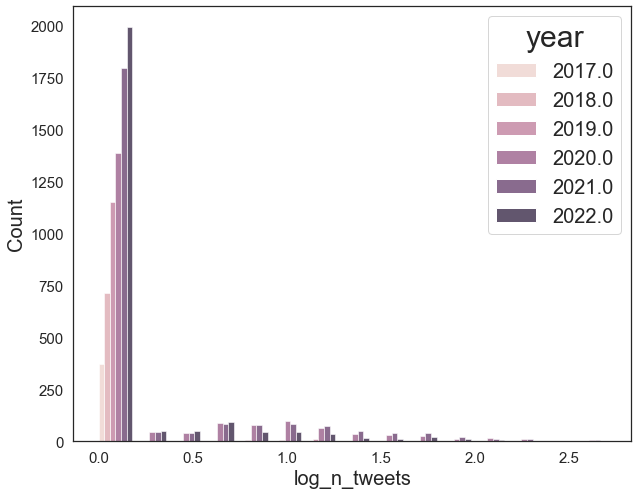

In [803]:
sns.histplot(data=design_mat,x='log_n_tweets', hue='year',multiple='dodge')

## Prepare Data for Matching

In [78]:
# log transform some columns
design_mat['log_input_len'] = np.log10(design_mat['input_len'])
design_mat['log_ins_rank_min'] = np.log10(design_mat['ins_rank_min'])
design_mat['log_ins_rank_avg'] = np.log10(design_mat['ins_rank_avg'])
design_mat['log_ins_rank_max'] = np.log10(design_mat['ins_rank_max'])
design_mat['log_author_cite_max'] = np.log10(1+design_mat['author_cite_max'])
design_mat['log_author_cite_avg'] = np.log10(1+design_mat['author_cite_avg'])
design_mat['log_author_cite_min'] = np.log10(1+design_mat['author_cite_min'])

In [79]:
Ns = ['c365', 'c1095', 'c1825']
A = 'arxiv_first'
Y = 'binary_decision'
C_cols = ['year',
 'log_input_len',
 'log_n_tweets',
 'n_fig',
 'n_ref',
 'n_sec',
 'sub_fluency',
 'cluster',
 'n_author',
 'fst_reported_f',
 'any_reported_f',
 'cnt_reported_f',
 'demo_no_us',
 'log_ins_rank_min',
 'log_ins_rank_avg',
 'log_ins_rank_max',
 'log_author_cite_min',
 'log_author_cite_avg',
 'log_author_cite_max'
]

C_vars = ['C(year)',
 'log_input_len',
 'log_n_tweets',
 'n_fig',
 'n_ref',
 'n_sec',
 'sub_fluency',
 'C(cluster)',
 'n_author',
 'C(fst_reported_f)',
 'C(any_reported_f)',
 'cnt_reported_f',
 'C(demo_no_us)',
 'log_ins_rank_min',
 'log_ins_rank_avg',
 'log_ins_rank_max',
 'log_author_cite_min',
 'log_author_cite_avg',
 'log_author_cite_max'
]

In [99]:
## remove NAs in covariates
design_mat = design_mat[~design_mat[C_cols].isna().any(axis=1)]

In [100]:
design_mat.to_csv('./design_mat.csv',header=True,index=False)

In [103]:
## (optional) create cosine-similarity matrix
# emb_df = pd.read_csv(DATA_PATH / 'submission_specter_embedding.csv')
# utils.lit_eval_df(emb_df, ['encoded_vec'])

In [160]:
## load back matched df

In [162]:
def load_matched_df(path, df):
    matched_design_mat = pd.read_csv(path).drop('Unnamed: 0',axis=1)
    matched_design_mat=matched_design_mat[~matched_design_mat.matched_set.isna()]
    return pd.concat([
        matched_design_mat.iloc[::2].assign(grp='treated'),
        matched_design_mat.iloc[1::2].assign(grp='control'),]
    )

#### Matched Data
1. https://www.dropbox.com/s/1y75t3mw6a70aj1/fb_matched_design_mat_ordered.csv?dl=0
2. https://www.dropbox.com/s/4fl3wa4wq15zqwr/matched_design_mat_ordered.csv?dl=0

In [352]:
## without fine-balance
matched_dat = load_matched_df('matched_design_mat_ordered.csv', design_mat)

## with fine-balance
fb_matched_dat = load_matched_df('fb_matched_design_mat_ordered.csv', design_mat)

In [473]:
cluster_df = design_mat.groupby('cluster').apply(lambda s: 
    s.groupby('primary_keyword').size().sort_values(ascending=False).iloc[:5],

                                   ).to_frame('count').reset_index()

In [488]:
for i in range(20):
    print(cluster_df[cluster_df.cluster==i])

   cluster         primary_keyword  count
0        0  reinforcement learning     18
1        0           meta-learning     17
2        0           deep learning     13
3        0   unsupervised learning     11
4        0              robustness     10
   cluster                     primary_keyword  count
5        1              reinforcement learning    116
6        1                       deep learning     47
7        1             representation learning     11
8        1  model-based reinforcement learning     10
9        1                     computer vision      9
    cluster                primary_keyword  count
10        2                  deep learning     31
11        2              generative models     13
12        2  convolutional neural networks      8
13        2         reinforcement learning      8
14        2        representation learning      7
    cluster            primary_keyword  count
15        3              deep learning     57
16        3  recurrent neural ne

### Table One

In [491]:
design_mat=pd.read_csv('./design_mat.csv')

In [147]:
import tableone
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [407]:
def constrcut_tableone(matched, df):
    return tableone.TableOne(pd.concat([matched,
                                      df[~df.arxiv_first].assign(grp='unmatched')]
                            )[C_cols+['grp']].reset_index(), #.assign(grpi=lambda s:s['grp']).set_index(['grpi','submission_id']),
                           categorical=['cluster','demo_no_us','fst_reported_f', 'any_reported_f'],
                           groupby=['grp'],overall=False, smd=True, missing=False,
                           order={'cluster':range(20)},
#                              rename={'control':'Matched Comparison Articles', 'treated': 'Early arXiv\'ed Papers',
#                                     'unmatched': 'Non-Early arXiv\'ed Papers'},
                           pval=False
    )

In [492]:
t1_fb_matched = constrcut_tableone(fb_matched_dat,design_mat).tableone

In [493]:
t1_fb_matched.columns=t1_fb_matched.columns.get_level_values(1)


In [494]:
pd.concat([fb_matched_dat,
            design_mat[~design_mat.arxiv_first].assign(grp='unmatched')]
    )[C_cols+['grp']].groupby('grp').size()

grp
control      1486
treated      1486
unmatched    7493
dtype: int64

In [353]:
t1_matched = constrcut_tableone(matched_dat,design_mat)

t1_fb_matched = constrcut_tableone(fb_matched_dat,design_mat)

In [495]:
t1_fb_matched_print=(t1_fb_matched[[t1_fb_matched.columns[i] for i in [1,2,0,3,5]]]
  .rename({'control':'Matched Comparison Articles', 
          'treated': 'Early arXiv\'ed Papers (Treated Group)',
            'unmatched': 'Non-Early arXiv\'ed Papers (Unmatched)',
           'SMD (treated,unmatched)': 'SMD (Before Matching)',
           'SMD (control,treated)': 'SMD (After Matching)',
          },axis=1
        )
)

In [496]:
def rename_index(s):
    s = list(s)
    s[0] = r"\texttt{" + s[0].split(',')[0].replace('_','\_')+r"}"
    return tuple(s)

In [497]:
t1_fb_matched_print.index=t1_fb_matched_print.index.map(rename_index)

In [498]:
print(t1_fb_matched_print.to_latex(escape=False))

\begin{tabular}{lllllll}
\toprule
                                &      & Early arXiv'ed Papers (Treated Group) & Non-Early arXiv'ed Papers (Unmatched) & Matched Comparison Articles & SMD (Before Matching) & SMD (After Matching) \\
\midrule
\texttt{n} & {} &                                  1486 &                                  7493 &                        1486 &                       &                      \\
\texttt{index} &      &                        1485.0 (858.2) &                       4447.8 (2585.8) &              1486.0 (858.2) &                 1.538 &               -0.001 \\
\texttt{year} &      &                          2020.8 (0.9) &                          2020.3 (1.5) &                2020.8 (0.9) &                -0.447 &               -0.001 \\
\texttt{log\_input\_len} &      &                             4.0 (0.2) &                             4.0 (0.2) &                   4.0 (0.2) &                -0.355 &               -0.002 \\
\texttt{n\_fig} &      &   

**TLDR**  Matched okay, no need to additionaly matched on specter cosine similarty and/or adding fine-balance on topic cluster

## DiD with NOC

### Sanity Check:
NB regression for NOC

In [489]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [80]:
C_formula = '+'.join(C_vars)
formula = f"{A} + " + C_formula

In [332]:
nb_noc = [smf.negativebinomial(formula=f"np.log10(1+{n}) ~ {formula}", 
                               data=design_mat).fit(method='bfgs', maxiter=1000) for n in Ns]

         Current function value: 0.920654
         Iterations: 42
         Function evaluations: 67
         Gradient evaluations: 57
         Current function value: 1.015871
         Iterations: 78
         Function evaluations: 159
         Gradient evaluations: 147
         Current function value: 1.339804
         Iterations: 46
         Function evaluations: 86
         Gradient evaluations: 74


In [270]:
Y_unadj = smf.ols(formula=f"{Y} ~ {formula}", data=design_mat).fit()

In [271]:
Y_unadj.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        binary_decision   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     30.75
Date:                Sun, 18 Jun 2023   Prob (F-statistic):          4.91e-221
Time:                        22:42:38   Log-Likelihood:                -5733.8
No. Observations:                8979   AIC:                         1.155e+04
Df Residuals:                    8937   BIC:                         1.185e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -2.3783      0.255     -9.317      0.000      -2.879      -1.878
arxiv_first[T.True]           0.1043      0.014      7.672      0.000       0.078       0.131
C(year)[T.2018]              -0.0813      0.029     -2.764      0.006      -0.139      -0.024
C(year)[T.2019]              -0.1448      0.028     -5.232      0.000      -0.199      -0.091
C(year)[T.2020]              -0.2390      0.027     -8.880      0.000      -0.292      -0.186
C(year)[T.2021]              -0.2027      0.030     -6.771      0.000      -0.261      -0.144
C(year)[T.2022]              -0.2117      0.027     -7.754      0.000      -0.265      -0.158
C(cluster)[T.1]               0.0515      0.032      1.627      0.104      -0.011       0.114
C(cluster)[T.2]               0.0503      0.037      1.376      0.169      -0.021       0.122
C(cluster)[T.3]               0.0340      0.033      1.038      0.300      -0.030       0.098
C(cluster)[T.4]              -0.0231      0.030     -0.782      0.434      -0.081       0.035
C(cluster)[T.5]              -0.0434      0.030     -1.429      0.153      -0.103       0.016
C(cluster)[T.6]               0.0532      0.032      1.655      0.098      -0.010       0.116
C(cluster)[T.7]              -0.0343      0.028     -1.233      0.218      -0.089       0.020
C(cluster)[T.8]              -0.1020      0.034     -2.987      0.003      -0.169      -0.035
C(cluster)[T.9]              -0.0400      0.031     -1.306      0.192      -0.100       0.020
C(cluster)[T.10]              0.0541      0.030      1.804      0.071      -0.005       0.113
C(cluster)[T.11]             -0.0714      0.031     -2.280      0.023      -0.133      -0.010
C(cluster)[T.12]              0.0177      0.031      0.576      0.564      -0.042       0.078
C(cluster)[T.13]              0.0182      0.034      0.533      0.594      -0.049       0.085
C(cluster)[T.14]              0.0307      0.033      0.922      0.357      -0.035       0.096
C(cluster)[T.15]             -0.0218      0.035     -0.630      0.529      -0.090       0.046
C(cluster)[T.16]             -0.0029      0.036     -0.082      0.935      -0.073       0.067
C(cluster)[T.17]             -0.0012      0.034     -0.036      0.971      -0.068       0.066
C(cluster)[T.18]              0.0191      0.034      0.567      0.571      -0.047       0.085
C(cluster)[T.19]             -0.0359      0.034     -1.062      0.288      -0.102       0.030
C(fst_reported_f)[T.True]    -0.0161      0.020     -0.789      0.430      -0.056       0.024
C(any_reported_f)[T.True]    -0.0140      0.025     -0.567      0.571      -0.062       0.034
C(demo_no_us)[T.True]         0.0031      0.013      0.243      0.808      -0.022       0.028
log_input_len                 0.3725      0.034     10.830      0.000      

**TLDR** NCO is associated with treatment variable.

## Studies

In [730]:
def get_ci_by_level(df, y, formula, level_col, level_vars, level_lb, grp_name='level', all_lb='all',alpha=0.05):
    mus = []
    models = []
    for lv, lb in zip([None,]+level_vars, [all_lb,]+level_lb):
        dat = df[df[level_col] == lv] if lv is not None else df

        did_dichi = smf.ols(
            formula=f"{y} ~ {formula}".strip(),
            data=dat,
        ).fit()
        models.append(did_dichi)
        mus.append(pd.DataFrame([np.hstack(
            [[lb], [float(did_dichi.pvalues.iloc[1])],[did_dichi.params.iloc[1]], 
             did_dichi.conf_int(alpha).iloc[1].values,
             did_dichi.nobs,
            ])],
            columns=['var','pval','r','ll','hl','n'])
                  )

    mus=pd.concat(mus).assign(grp=grp_name)
    mus['pval']=mus['pval'].values.astype(float)
    mus['r']=mus['r'].values.astype(float)
    mus['ll']=mus['ll'].values.astype(float)
    mus['hl']=mus['hl'].values.astype(float)
    mus['n']=mus['n'].values.astype(float).astype(int).astype(str)
    return mus, models

In [499]:
## define NCO and prepare for DiD
NCOs = ['N1', 'N2', 'N3']
design_mat = design_mat.reset_index()
design_mat['N1'] = design_mat[Y] - 1.*(design_mat['c365']>=10)
design_mat['N2'] = design_mat[Y] - 1.*(design_mat['c1825']>=500)
design_mat['N3'] = design_mat[Y] - 1.*(design_mat['c1095']>=100)



In [500]:
design_mat['inst_level'] =\
    design_mat['log_ins_rank_min'].apply(lambda s : 'L' if s < 1 else ('M' if s < 2 else 'H')
)

design_mat['author_level'] =\
    design_mat['log_author_cite_avg'].apply(lambda s : 'L' if s < 2 else ('M' if s < 4 else 'H')
)



In [845]:
dat = fb_matched_dat.merge(
    design_mat[['submission_id','inst_level','author_level','c730']+NCOs], 
    on='submission_id', 
    how='left')



In [502]:
inst_formula = f"{A} + " + '+'.join([var for var in C_vars if 'inst_rank' not in var])
author_formula = f"{A} + " + '+'.join([var for var in C_vars if 'author_cite' not in var])

In [503]:
# another sanity check
Y_matched = smf.logit(formula=f"{Y} ~ {formula}", data=dat).fit()

Optimization terminated successfully.
         Current function value: 0.623841
         Iterations 5


In [504]:
Y_matched.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        binary_decision   No. Observations:                 2972
Model:                          Logit   Df Residuals:                     2931
Method:                           MLE   Df Model:                           40
Date:                Mon, 19 Jun 2023   Pseudo R-squ.:                 0.09475
Time:                        20:09:49   Log-Likelihood:                -1854.1
converged:                       True   LL-Null:                       -2048.1
Covariance Type:            nonrobust   LLR p-value:                 1.418e-58
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -9.6595      2.261     -4.273      0.000     -14.090      -5.229
arxiv_first[T.True]           0.4312      0.079      5.463      0.000       0.277       0.586
C(year)[T.2019]              -0.9989      0.432     -2.310      0.021      -1.846      -0.151
C(year)[T.2020]              -1.4894      0.383     -3.891      0.000      -2.240      -0.739
C(year)[T.2021]              -1.5058      0.396     -3.802      0.000      -2.282      -0.730
C(year)[T.2022]              -1.3516      0.387     -3.490      0.000      -2.111      -0.593
C(cluster)[T.1]               0.3437      0.254      1.352      0.176      -0.155       0.842
C(cluster)[T.2]               0.1012      0.284      0.356      0.722      -0.456       0.659
C(cluster)[T.3]               0.3107      0.267      1.162      0.245      -0.213       0.835
C(cluster)[T.4]              -0.0385      0.219     -0.176      0.861      -0.469       0.392
C(cluster)[T.5]              -0.3339      0.232     -1.438      0.150      -0.789       0.121
C(cluster)[T.6]               0.3867      0.243      1.589      0.112      -0.090       0.864
C(cluster)[T.7]              -0.2033      0.220     -0.923      0.356      -0.635       0.228
C(cluster)[T.8]              -0.7470      0.269     -2.778      0.005      -1.274      -0.220
C(cluster)[T.9]              -0.1025      0.248     -0.413      0.680      -0.589       0.384
C(cluster)[T.10]              0.4193      0.232      1.808      0.071      -0.035       0.874
C(cluster)[T.11]             -0.2984      0.236     -1.262      0.207      -0.762       0.165
C(cluster)[T.12]              0.2425      0.240      1.012      0.311      -0.227       0.712
C(cluster)[T.13]              0.1249      0.280      0.446      0.655      -0.424       0.674
C(cluster)[T.14]              0.2766      0.278      0.994      0.320      -0.269       0.822
C(cluster)[T.15]             -0.0859      0.288     -0.298      0.765      -0.650       0.479
C(cluster)[T.16]             -0.2446      0.296     -0.826      0.409      -0.825       0.336
C(cluster)[T.17]             -0.0857      0.276     -0.310      0.756      -0.627       0.456
C(cluster)[T.18]              0.0516      0.268      0.193      0.847      -0.473       0.576
C(cluster)[T.19]              0.0188      0.254      0.074      0.941      -0.479       0.517
C(fst_reported_f)[T.True]    -0.2200      0.193     -1.142      0.253      -0.597       0.158
C(any_reported_f)[T.True]     0.4196      0.236      1.780      0.075      -0.043       0.882
C(demo_no_us)[T.True]        -0.0062      0.105     -0.059      0.953      -0.212       0.199
log_input_len                 1.4215      0.272      5.221      0.000       0.888       1.955
n_fig                         0.0186      0.006      3.121      0.002       0.007       0.030
n_ref                         0.0082      0.002      3.373      0.001       0.003       0.013
n_sec                         0.0229      0.0

### DiD on Matched Samples

In [543]:
DiD = [smf.ols(
            formula=f"{y} ~ {formula}".strip(),
            data=d,
        ).fit() for y,d  in zip(NCOs,[dat,dat[dat.year<=2020],dat[dat.year<=2018]])]

In [920]:
DiD[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     N1   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     7.287
Date:                Wed, 21 Jun 2023   Prob (F-statistic):           1.04e-37
Time:                        02:28:42   Log-Likelihood:                -2234.8
No. Observations:                2972   AIC:                             4552.
Df Residuals:                    2931   BIC:                             4797.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -1.2955      0.536     -2.416      0.016      -2.347      -0.244
arxiv_first[T.True]           0.0195      0.019      1.025      0.305      -0.018       0.057
C(year)[T.2019]              -0.1482      0.098     -1.518      0.129      -0.340       0.043
C(year)[T.2020]              -0.1539      0.084     -1.833      0.067      -0.319       0.011
C(year)[T.2021]              -0.0836      0.087     -0.956      0.339      -0.255       0.088
C(year)[T.2022]               0.0337      0.085      0.396      0.692      -0.133       0.201
C(cluster)[T.1]               0.0461      0.062      0.743      0.457      -0.075       0.168
C(cluster)[T.2]              -0.0804      0.069     -1.169      0.242      -0.215       0.054
C(cluster)[T.3]               0.0541      0.065      0.833      0.405      -0.073       0.181
C(cluster)[T.4]              -0.0817      0.053     -1.542      0.123      -0.186       0.022
C(cluster)[T.5]              -0.1755      0.055     -3.168      0.002      -0.284      -0.067
C(cluster)[T.6]              -0.0524      0.059     -0.892      0.372      -0.168       0.063
C(cluster)[T.7]              -0.0252      0.053     -0.473      0.636      -0.130       0.079
C(cluster)[T.8]              -0.2646      0.063     -4.211      0.000      -0.388      -0.141
C(cluster)[T.9]              -0.0210      0.060     -0.350      0.726      -0.139       0.097
C(cluster)[T.10]             -0.0946      0.056     -1.682      0.093      -0.205       0.016
C(cluster)[T.11]             -0.1560      0.057     -2.750      0.006      -0.267      -0.045
C(cluster)[T.12]             -0.0150      0.058     -0.258      0.797      -0.129       0.099
C(cluster)[T.13]              0.0743      0.068      1.097      0.273      -0.058       0.207
C(cluster)[T.14]              0.0061      0.068      0.091      0.928      -0.127       0.139
C(cluster)[T.15]             -0.0343      0.070     -0.493      0.622      -0.171       0.102
C(cluster)[T.16]             -0.0311      0.071     -0.437      0.662      -0.170       0.108
C(cluster)[T.17]             -0.0969      0.067     -1.444      0.149      -0.229       0.035
C(cluster)[T.18]             -0.0462      0.064     -0.716      0.474      -0.172       0.080
C(cluster)[T.19]              0.0246      0.062      0.398      0.691      -0.097       0.146
C(fst_reported_f)[T.True]    -0.0658      0.046     -1.445      0.149      -0.155       0.024
C(any_reported_f)[T.True]     0.0353      0.055      0.637      0.524      -0.073       0.144
C(demo_no_us)[T.True]         0.0311      0.025      1.231      0.218      -0.018       0.081
log_input_len                 0.2764      0.064      4.301      0.000       0.150       0.402
n_fig                         0.0020      0.001      1.450      0.147      

In [555]:
import scipy as sp
import scipy.stats as sps

### Plots

In [721]:
import forestplot as fp
def forest_plot(mus, plt=plt):
    df=fp.forestplot(fdt, estimate="r", ll="ll", hl="hl", varlabel="var", groupvar='grp',
        color_alt_rows=True, capitalize="Capitalize", pval='pval',
        annote=['n',"est_ci", "formatted_pval",], annoteheaders=[r"$n$","Est. (95% CI)", r"$p$-Value"],
     rightannote=[], right_annoteheaders=[],
        xlabel="Estimated ATET",
        figsize=(3,4), table=True,
        fontfamily='inconsolata', xticks=[-0.1,0,0.1,0.2],
        marker='D', markersize=35,
        xlinestyle=(0, (10,5)), return_df=True,
    )
    return df


#### 1. $N = 1\{\text{1-year cite} > 10 \}$

In [505]:
print(len(dat))

2972


In [731]:
n1_inst = get_ci_by_level(dat, y='N1', formula=inst_formula,
                          all_lb='All Institutions',
                          level_col='inst_level', level_vars=['L','M','H'],
                          level_lb=['top-10', '10-100', 'others'], grp_name='Min Institution Rank'
)

n1_author = get_ci_by_level(dat, y='N1', formula=author_formula,
                          all_lb='All Authors',
                          level_col='inst_level', level_vars=['L','M','H'],
                          level_lb=['<100', '100-10000', '>10000'], grp_name='Max Author Citation'
                           )

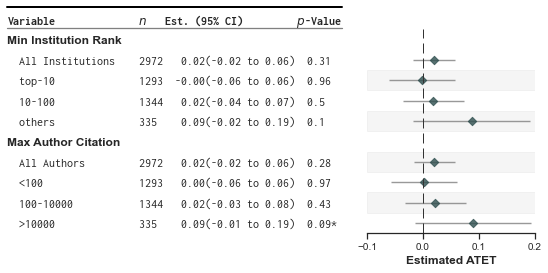

In [733]:
fdt=pd.concat([n1_inst[0],n1_author[0]]).reset_index(drop=True)
_=forest_plot(fdt)
plt.tight_layout()
plt.savefig('./n1fp.pdf',bbox_inches='tight')

#### 2. $N = 1\{\text{2-year cite} > 100 \}$

In [511]:
print(len(dat[dat.year<=2020]))

1140


In [734]:
n2_inst = get_ci_by_level(dat[dat.year<=2020], y='N2', formula=inst_formula,
                          all_lb='All Institutions',
                          level_col='inst_level', level_vars=['L','M','H'],
                          level_lb=['top-10', '10-100', 'others'], grp_name='Min Institution Rank'
)

n2_author = get_ci_by_level(dat[dat.year<=2020], y='N2', formula=author_formula,
                            all_lb='All Authors',
                          level_col='inst_level', level_vars=['L','M','H'],
                          level_lb=['<100', '100-10000', '>10000'], grp_name='Max Author Citation'
                           )

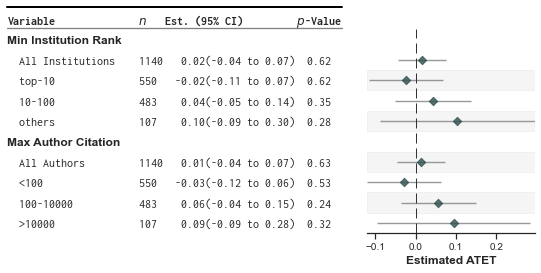

In [735]:
fdt=pd.concat([n2_inst[0],n2_author[0]]).reset_index(drop=True)
_=forest_plot(fdt)
plt.tight_layout()
plt.savefig('./n2fp.pdf',bbox_inches='tight')

#### 3. $N = 1\{\text{5-year cite} > 500 \}$

In [515]:
# too few data point!
print(len(dat[dat.year<=2018]))

40


In [516]:
n3_inst = get_ci_by_level(dat[dat.year<=2018], y='N2', formula=inst_formula,
                          level_col='inst_level', level_vars=['L','M','H'],
                          level_lb=['top-10', '10-100', 'others'], grp_name='Min Inst Rank'
)

n3_author = get_ci_by_level(dat[dat.year<=2018], y='N2', formula=author_formula,
                          level_col='inst_level', level_vars=['L','M','H'],
                          level_lb=['<100', '100-10000', '>10000'], grp_name='Max Author Citation'
                           )

### Sensitivity Analysis

#### Dichotmization at various levels

In [913]:
full_res = {}
per_group_res = {}

for (N, t) in [
    ('c365', 10),
    ('c365', 20),
    ('c365', 50),
    ('c365', 100),
    ('c730', 10),
    ('c730', 50),
    ('c730', 100),
    ('c730', 500),
    ('c730', 1000),
    ('c1095', 10),
    ('c1095', 50),
    ('c1095', 100),
    ('c1095', 500),
    ('c1095', 1000),
]:
    sel = {
        'c365': dat.year <= 2022,
        'c730': dat.year <= 2021,
        'c1095': dat.year <= 2020,
    }[N]
    dat['N_'] = dat[Y] - 1.*(dat[N]>=t)
    did_inst = get_ci_by_level(dat[sel], y='N_', formula=inst_formula,
                          all_lb='All Institutions',
                          level_col='inst_level', level_vars=['L','M','H'],
                          level_lb=['top-10', '10-100', 'others'], grp_name='Min Institution Rank'
    )

    did_author = get_ci_by_level(dat[sel], y='N_', formula=author_formula,
                                all_lb='All Authors',
                              level_col='inst_level', level_vars=['L','M','H'],
                              level_lb=['<100', '100-10000', '>10000'], grp_name='Max Author Citation'
                               )
    key=f"{N}_{t}"
    fdt=pd.concat([did_inst[0],did_author[0]]).reset_index(drop=True)
    per_group_res[key] = fdt
    
    full_res[key] = smf.ols(
            formula=f"N_ ~ {formula}".strip(),
            data=dat[sel],
        ).fit()

    


#### Log-transform

In [903]:
full_res_log = {}
per_group_res_log={}
for N in ['c365','c730','c1095']:
    log_C = {
        'c365': 2.8,
        'c730': 3.3,
        'c1095': 3.5,
    }[N]
    sel = {
        'c365': dat.year <= 2022,
        'c730': dat.year <= 2021,
        'c1095': dat.year <= 2020,
    }[N]
    key=f"{N}"
    dat['N_log_'] = dat[Y] - np.log10(1+dat[N])/log_C
    
    did_inst = get_ci_by_level(dat[sel], y='N_log_', formula=inst_formula,
                          all_lb='All Institutions',
                          level_col='inst_level', level_vars=['L','M','H'],
                          level_lb=['top-10', '10-100', 'others'], grp_name='Min Institution Rank'
    )

    did_author = get_ci_by_level(dat[sel], y='N_log_', formula=author_formula,
                                all_lb='All Authors',
                              level_col='inst_level', level_vars=['L','M','H'],
                              level_lb=['<100', '100-10000', '>10000'], grp_name='Max Author Citation'
                               )

    fdt=pd.concat([did_inst[0],did_author[0]]).reset_index(drop=True)
    per_group_res_log[key] = fdt

    full_res_log[key] = smf.ols(
    formula=f"N_log_ ~ {formula}".strip(),
            data=dat[sel],
        ).fit()

#### Log-transform

In [904]:

for k, fdt in full_res_log.items():
    print(f"{k:10}: {fdt.params[1]:6.3f} ({(fdt.pvalues[1]):.4f})")

c365      :  0.048 (0.0069)
c730      :  0.008 (0.6905)
c1095     : -0.016 (0.5269)


c365
c730
c1095


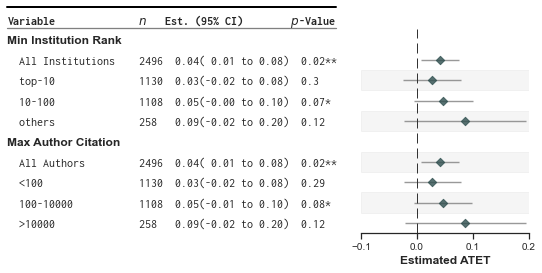

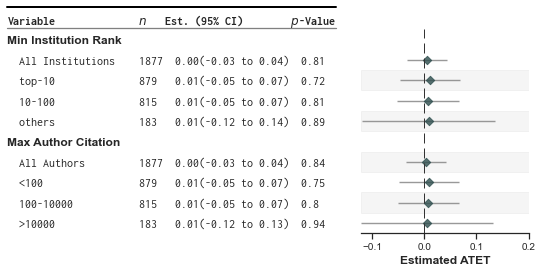

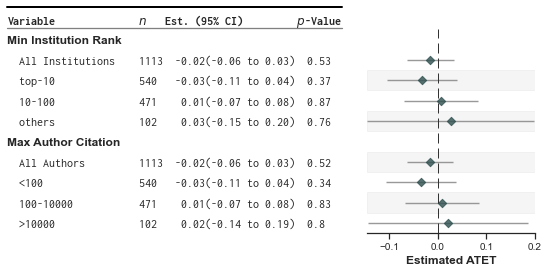

In [902]:

for k, fdt in per_group_res_log.items():
    print(k)
    _=forest_plot(fdt)

In [916]:
for k, fdt in full_res.items():
    print(f"{k:10}: {fdt.params[1]:6.3f} ({(fdt.pvalues[1]):.4f})")

c365_10   :  0.019 (0.3054)
c365_20   :  0.067 (0.0002)
c365_50   :  0.090 (0.0000)
c365_100  :  0.094 (0.0000)
c730_10   : -0.047 (0.0256)
c730_50   :  0.038 (0.0835)
c730_100  :  0.078 (0.0002)
c730_500  :  0.096 (0.0000)
c730_1000 :  0.098 (0.0000)
c1095_10  : -0.111 (0.0001)
c1095_50  : -0.016 (0.5980)
c1095_100 :  0.015 (0.6183)
c1095_500 :  0.088 (0.0021)
c1095_1000:  0.087 (0.0025)


c365_10


c365_20


c365_50


c365_100


c730_10


c730_50


c730_100


c730_500


c730_1000


c1095_10


c1095_50


c1095_100


c1095_500


c1095_1000




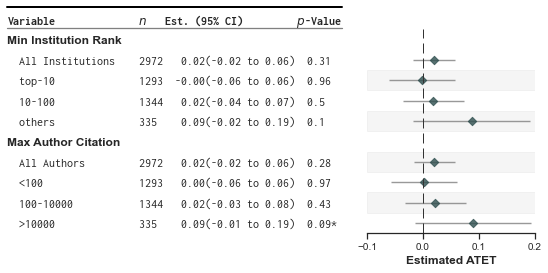

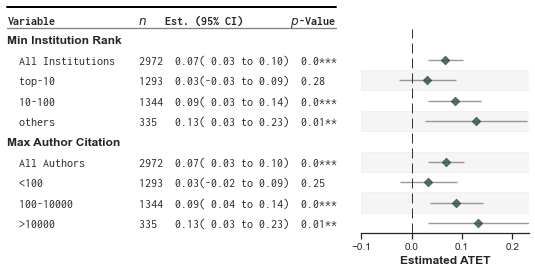

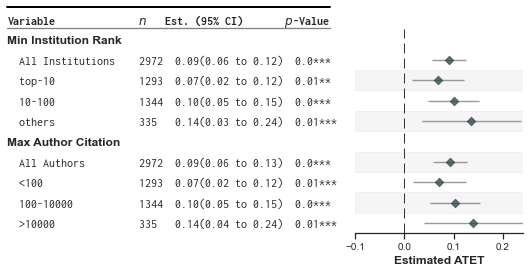

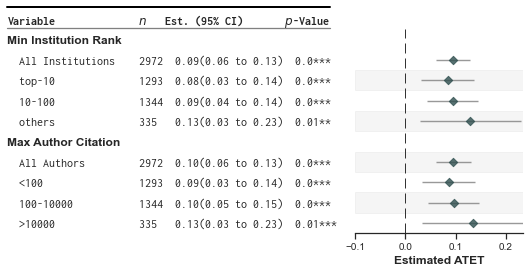

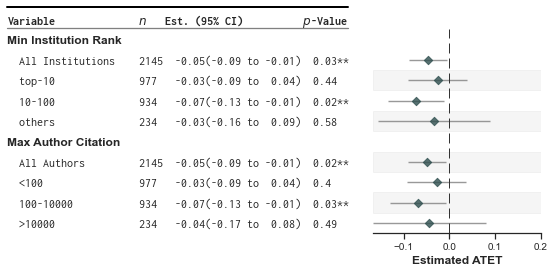

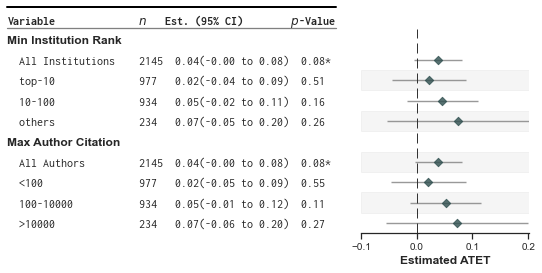

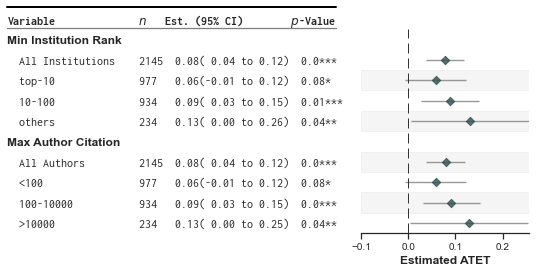

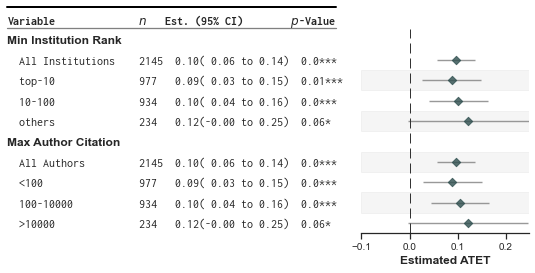

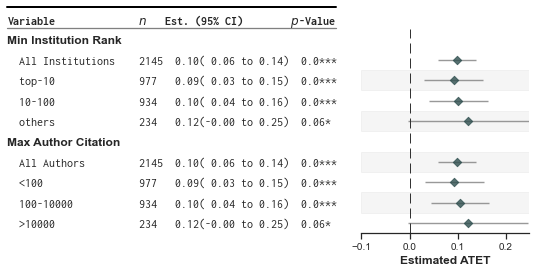

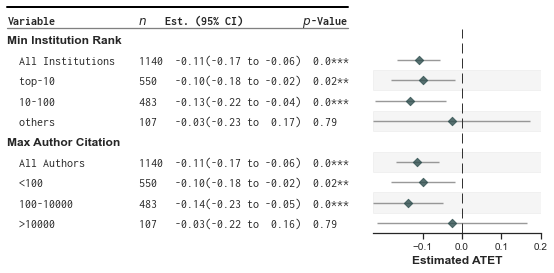

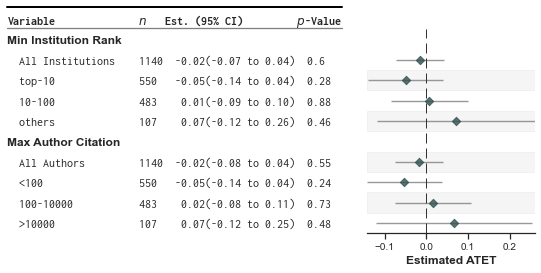

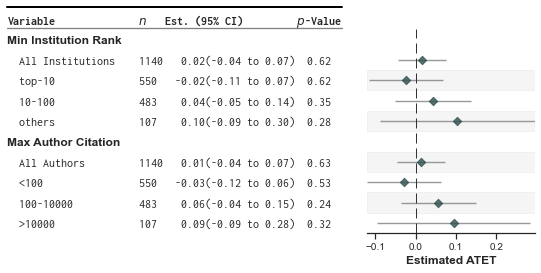

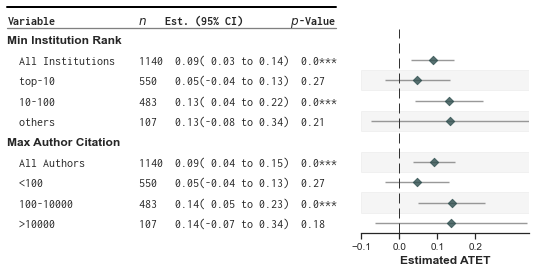

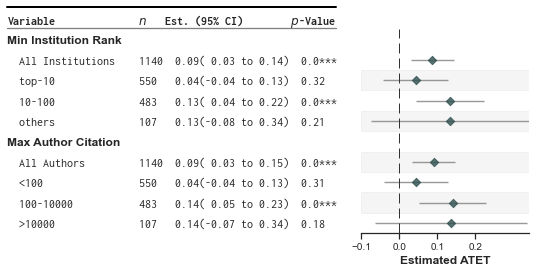

In [878]:
for k, fdt in per_group_res.items():
    print(k)
    _=forest_plot(fdt)
    print('\n')